# Figure 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pylab as plt
import delfi.distribution as dd
import time
from copy import deepcopy
import sys
sys.path.append("../../../setup")
sys.path.append("../../../simulator")
sys.path.append("../../../inference")
sys.path.append("../../../utils")
sys.path.append("../model/")
sys.path.append('../../')

import matplotlib as mpl
from common import col, svg, samples_nd
import netio
import viz
import importlib
from compare_samples import get_dist, evaluate_summ_stats
from find_pyloric import merge_samples, params_are_bounded
import dill as pickle

from find_pyloric import merge_datasets, merge_datasets_energy, find_pyloric_like, find_close_to_obs
from energy import select_ss_close_to_obs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
PANEL_A = '../svg/panel_a.svg'
PANEL_B = '../svg/panel_b.svg'
PANEL_C = '../svg/panel_c.svg'
PANEL_D = '../svg/panel_d.svg'

In [5]:
params_11 = netio.load_setup('collect_31D')
pyloric_sim = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)

('seed in cHH', None)


In [10]:
outfile = '../../results/11deg_post_pred/11_deg_post_pred.npz'
data_n = np.load(outfile)
sample_seeds = data_n["seeds"]
sample_params = data_n["params"]
sample_stats = data_n["stats"]
print('There are', len(sample_seeds), 'datapoints in this dataset')

There are 1124507 datapoints in this dataset


In [12]:
ratio_of_nan = (len(sample_seeds_all) - len(sample_seeds)) / len(sample_seeds_all) * 100
print("Overall percentage of NaNs", ratio_of_nan, "%")

Overall percentage of NaNs 10.753412698412697 %


### Load prior simulations for getting the std and mean of summstats

In [6]:
datafile = '../../results/prior_samples_after_classifier/samples_full_3.npz'
data = np.load(datafile)

params = data['params']
stats = data['stats']
seeds = data['seeds']

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

### Load experimental data

In [7]:
npz = np.load('../../results/experimental_data/summstats_prep845_082_0044.npz')
observation = npz['summ_stats']

npz = np.load('../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']

In [8]:
observation

array([1.17085859e+03, 2.06036434e+02, 2.14307031e+02, 4.12842187e+02,
       2.75164844e+02, 4.20460938e+01, 4.81925781e+02, 7.38278906e+02,
       1.75970382e-01, 1.83034085e-01, 3.52597820e-01, 2.35011166e-01,
       3.59104797e-02, 4.11600328e-01, 6.30544893e-01, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00])

### Select only the ones that are close to the observation

In [9]:
stats_std*0.01

array([1.02627304e+01, 7.45749320e+00, 6.67399653e+00, 5.56057901e+00,
       3.74952141e+00, 7.03324819e+00, 8.31305524e+00, 8.90978283e+00,
       3.08293428e-03, 3.49053123e-03, 2.94070659e-03, 1.64757951e-03,
       3.17512674e-03, 1.93512987e-03, 2.08303979e-03, 2.95139748e-01,
       6.37143175e-01, 3.58698940e-01])

In [10]:
num_std = np.asarray([0.02, 0.02, 0.02, 0.02, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [11]:
good_params, good_dat, good_seeds = select_ss_close_to_obs(sample_params, sample_stats, sample_seeds, observation, num_std=num_std, stats_std=stats_std[:15])

In [12]:
good_dat.shape

(55043, 30)

In [13]:
sample_stats = good_dat
sample_params = good_params
sample_seeds = good_seeds

In [15]:
#np.savez('../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz',
#         sample_stats=sample_stats, sample_params=sample_params, sample_seeds=sample_seeds)

# Panel A: Histogram for total energy

In [16]:
all_energies_per_spike = sample_stats[:, 18:21]
all_total_energies     = sample_stats[:, 21:24]

In [17]:
summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total     = np.sum(np.asarray(all_total_energies), axis=1)

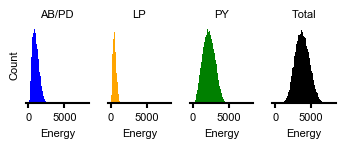

In [18]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 4, figsize=(4.0, 1))

    _ = ax[0].hist(all_total_energies[:,0]/1000, range=[0, 8000], bins=100, color='b')
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel('Energy')
    ax[0].tick_params(axis='both', which='major')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title('AB/PD')

    _ = ax[1].hist(all_total_energies[:,1]/1000, range=[0, 8000], bins=100, color='orange')
    #ax[1].set_ylabel('Count')
    ax[1].set_xlabel('Energy')
    ax[1].tick_params(axis='both', which='major')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title('LP')

    _ = ax[2].hist(all_total_energies[:,2]/1000, range=[0, 8000], bins=100, color='g')
    #ax[2].set_ylabel('Count')
    ax[2].set_xlabel('Energy')
    ax[2].tick_params(axis='both', which='major')
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title('PY')

    _ = ax[3].hist(summed_energies_total/1000, range=[0, 8000], bins=100, color='k')
    #ax[3].set_ylabel('Count')
    ax[3].set_xlabel('Energy')
    ax[3].tick_params(axis='both', which='major')
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['left'].set_visible(False)
    ax[3].axes.get_yaxis().set_ticks([])
    ax[3].set_title('Total')

    plt.subplots_adjust(wspace=0.3)
    
    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

# Panel B: Histogram for energy per spike

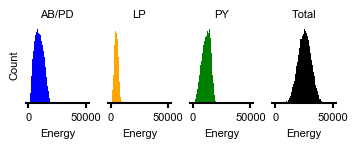

In [19]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 4, figsize=(4.0, 1))

    _ = ax[0].hist(all_energies_per_spike[:,0], range=[0, 50000], bins=100, color='b')
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel('Energy')
    ax[0].tick_params(axis='both', which='major')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title('AB/PD')

    _ = ax[1].hist(all_energies_per_spike[:,1], range=[0, 50000], bins=100, color='orange')
    #ax[1].set_ylabel('Count')
    ax[1].set_xlabel('Energy')
    ax[1].tick_params(axis='both', which='major')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title('LP')

    _ = ax[2].hist(all_energies_per_spike[:,2], range=[0, 50000], bins=100, color='g')
    #ax[2].set_ylabel('Count')
    ax[2].set_xlabel('Energy')
    ax[2].tick_params(axis='both', which='major')
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title('PY')

    _ = ax[3].hist(summed_energies_per_spike, range=[0, 50000], bins=100, color='k')
    #ax[3].set_ylabel('Count')
    ax[3].set_xlabel('Energy')
    #ax[3].tick_params(axis='both', which='major')
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['left'].set_visible(False)
    ax[3].axes.get_yaxis().set_ticks([])
    ax[3].set_title('Total')

    plt.subplots_adjust(wspace=0.3)
    
    plt.savefig(PANEL_B, facecolor='None', transparent=True)
    plt.show()

# Panel C: trace with highest and lowest energy

In [20]:
inds = np.argsort(summed_energies_total)
sorted_params = sample_params[inds]
sorted_seeds  = sample_seeds[inds]

In [21]:
num_samples = 5

show_xaxis = False
counter = 0

all_out_targets = []

cols = [col['CONSISTENT1'], col['CONSISTENT1']]

for counter in [0, len(sorted_params)-1]:
    params1 = sorted_params[counter]
    
    target_params = params1# * params_std_11 + params_mean_11
    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=sorted_seeds[counter])
    
    all_out_targets.append(out_target)

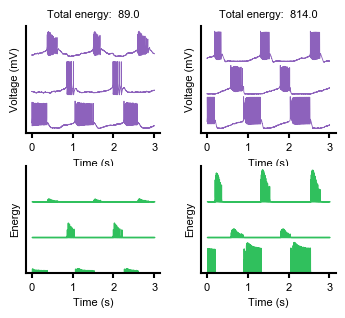

In [22]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.compare_low_and_high_energy_trace(
        all_out_targets,
        t,
        pyloric_sim[0].t,
        figsize=(4.0, 3.2),
        cols=cols,
    )
    plt.savefig(PANEL_C, facecolor='None', transparent=True)
    plt.show()

# Panel D: Energy scape

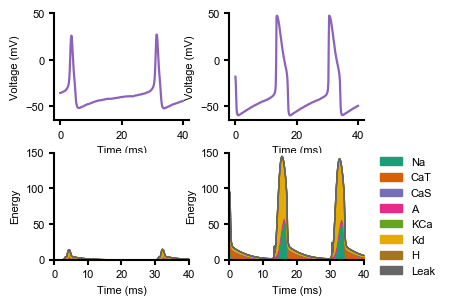

In [23]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.energy_scape(
        all_out_targets,
        t,
        pyloric_sim[0].t,
        figsize=(4.0, 3.2),
        cols=cols,
    )
    plt.savefig(PANEL_D, facecolor='None', transparent=True)
    plt.show()

# Assemble figure

In [24]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [25]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.4cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0.0*factor_svg),
           
    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(65*factor_svg, 0.0*factor_svg),
    
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 27*factor_svg),
    
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("d", 0*factor_svg, 0.0*factor_svg, **kwargs_text),
    ).move(65*factor_svg, 29.0*factor_svg)
)

!mkdir -p fig
f.save("../fig/fig2.svg")
svg('../fig/fig2.svg')

# Additional stuff


In [45]:
print('Energy per spike:  min: ', np.min(summed_energies_per_spike), ' max: ', np.max(summed_energies_per_spike),
      ' ratio: ', np.max(summed_energies_per_spike)/np.min(summed_energies_per_spike))
print('Energy total:      min: ', np.min(summed_energies_total), ' max: ', np.max(summed_energies_total),
      ' ratio: ', np.max(summed_energies_total)/np.min(summed_energies_total))

Energy per spike:  min:  6788.608130555542  max:  43919.740452343845  ratio:  6.4696237590531975
Energy total:      min:  848945.6118815772  max:  7542451.395313956  ratio:  8.884493057920514


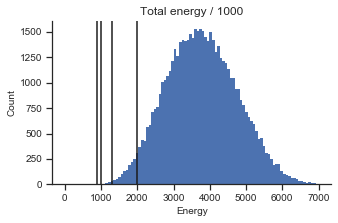

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

_ = ax.hist(summed_energies_total/1000, range=[0, 7000], bins=100)
ax.set_ylabel('Count', fontsize=10.0)
ax.set_xlabel('Energy', fontsize=10.0)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Total energy / 1000', fontsize=12.0)

ax.axvline(2000, color='k')
ax.axvline(1300, color='k')
ax.axvline(1000, color='k')
ax.axvline(900, color='k')

#plt.savefig('../results/energy/figs/hist_with_lines.pdf', bbox_inches='tight')